In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

## TODO: Remove later
_Code Refs_
https://github.com/tensorflow/tensorflow/blob/r2.0/tensorflow/lite/python/tflite_convert.py#L104
`converter_fn = lite.TFLiteConverter.from_keras_model_file
converter_kwargs["model_file"] = flags.keras_model_file`

Actual code in:
https://www.gitmemory.com/gargn
'''
model = tf.saved_model.load(export_dir)
concrete_func = model.signatures[
    tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([1, 28, 28])
converter = tf.lite.TFLiteConverter.from_concrete_function(concrete_func)
tflite_model = converter.convert()
open("/tmp/mnist_fashion/converted_model.tflite", "wb").write(tflite_model)
'''
Note that the model has been saved with tf.saved_model, and not with keras convience function.

    

In [2]:
import sys
sys.path.append('../')  # so that we can import libs from other chapters and utils

from utils import emnist_utils

In [3]:
######## GPU CONFIGS FOR RTX 2070 ###########
## Please ignore if not training on GPU ##
from tensorflow.keras import backend as K
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True  # dont allocate all memory at once
config.gpu_options.allocator_type = 'BFC'  #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc
config.gpu_options.per_process_gpu_memory_fraction = 2.0  # Use host memory as swap space, may not work on all architectures
session = InteractiveSession(config=config)
K.set_session(session)
##########################################

In [4]:
# Load train and test data from Chapter 1 location
train = {}
test = {}

train['features'], train['labels'] = emnist_utils.read_emnist('../Chapter1/data/emnist-bymerge-train-images-idx3-ubyte.gz', '../Chapter1/data/emnist-bymerge-train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = emnist_utils.read_emnist('../Chapter1/data/emnist-bymerge-test-images-idx3-ubyte.gz', '../Chapter1/data/emnist-bymerge-test-labels-idx1-ubyte.gz')

In [5]:
mappings = emnist_utils.map_emnist_labels("../Chapter1/data/emnist-bymerge-mapping.txt")

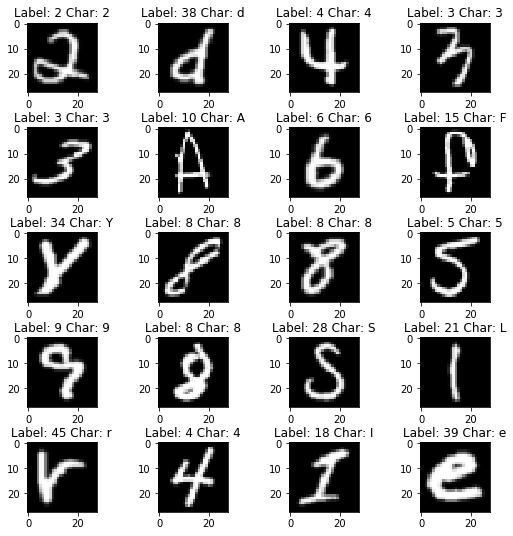

In [6]:
# Plot some images to verify we got the data right
emnist_utils.display_emnist_images(test['features'], test['labels'], mappings)

In [7]:
# Normalize the data
norm_train_features = keras.utils.normalize(train['features'])
norm_test_features = keras.utils.normalize(test['features'])

# one hot encode training labels
one_hot_train_labels = tf.one_hot(train['labels'], 47)
one_hot_test_labels = tf.one_hot(test['labels'], 47)

## Our first Convolutional Neural Network

In [8]:
# (1) First the input layer
inputs = keras.Input(shape=(28,28,), name='emnist_inp')
x = layers.Reshape((28, 28, 1))(inputs)  # since images are gray scale, they have only one channel

# (2) Learn 64 different filters, each 3x3 in size, with valid pooling, and (1,1) stride size
x = layers.Conv2D(64, (3, 3), activation='relu')(x)

# (3) Pooling layer
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# (4) Dimensions after pooling are 13x13x64. The 28x28 image is now 13x13 with 64 filters
x = layers.Flatten()(x)

# (5) Traditional dense/FC layers to use these inputs for classification
# This part is similar to previous model
x = layers.Dense(256, activation='relu', name='dense_1')(x)
x = layers.Dense(128, activation='relu', name='dense_2')(x)
outputs = layers.Dense(47, activation='softmax', name='predictions')(x)

cnn = keras.Model(inputs=inputs, outputs=outputs, name='cnn_model_1')
cnn.summary()

Model: "cnn_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emnist_inp (InputLayer)      [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2769152   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               

In [9]:
# Lets compile the model and train it
cnn.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
history = cnn.fit(norm_train_features, one_hot_train_labels, epochs=10, batch_size=128)

Epoch 1/10
697932/697932 [==============================] - 40s 58us/sample - loss: 0.4612 - accuracy: 0.8452
Epoch 2/10
697932/697932 [==============================] - 39s 55us/sample - loss: 0.3181 - accuracy: 0.8856
Epoch 3/10
697932/697932 [==============================] - 39s 55us/sample - loss: 0.2882 - accuracy: 0.8937
Epoch 4/10
697932/697932 [==============================] - 39s 55us/sample - loss: 0.2681 - accuracy: 0.8995
Epoch 5/10
697932/697932 [==============================] - 39s 55us/sample - loss: 0.2525 - accuracy: 0.9040
Epoch 6/10
697932/697932 [==============================] - 39s 55us/sample - loss: 0.2391 - accuracy: 0.9079
Epoch 7/10
697932/697932 [==============================] - 39s 55us/sample - loss: 0.2279 - accuracy: 0.9109
Epoch 8/10
697932/697932 [==============================] - 39s 55us/sample - loss: 0.2176 - accuracy: 0.9140
Epoch 9/10
697932/697932 [==============================] - 39s 55us/sample - loss: 0.2091 - accuracy: 0.9164
Epoch 10/1

In [11]:
# Evaluate the model on the test set
cnn.evaluate(norm_test_features, one_hot_test_labels, 47)

116323/116323 [==============================] - 7s 59us/sample - loss: 0.3382 - accuracy: 0.8901


[0.33816879281153145, 0.8900991]

In [ ]:
# Visualize the training
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['accuracy', 'loss'], loc='right')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions = cnn.predict(norm_test_features)  # generates a probability for each label
y_pred = np.argmax(predictions, axis=1)  # choose the one with the highest value as the output label

print('Confusion Matrix')
confusion = emnist_utils.generate_confusion_matrix(test['labels'], y_pred)
print(confusion)
emnist_utils.plot_confusion_matrix(confusion, mappings)

## New Deeper Network
This network will be used to demonstrate use of TensorBoard and generalization techniques like dropout and batch norm.

In [13]:
# (1) First the input layer
inputs = keras.Input(shape=(28,28,), name='emnist_inp')
x = layers.Reshape((28, 28, 1))(inputs)  # since images are gray scale, they have only one channel

# (2.1) Learn 128 different filters, each 3x3 in size, with valid pooling, and (1,1) stride size
x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(x)  # 2 convolutional layers
# (3.1) Pooling layer
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# (2.2) Learn 64 different filters, each 3x3 in size, with valid pooling, and (1,1) stride size
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)  # 2 convolutional layers
# (3.2) Pooling layer
x = layers.MaxPooling2D(pool_size=(2, 2))(x)


# (4) Dimensions after pooling are 5x5x64. The 28x28 image is now 5x5 with 64 filters
x = layers.Flatten()(x)

# (5) Traditional dense/FC layers to use these inputs for classification
# This part is similar to previous model
x = layers.Dense(256, activation='relu', name='dense_1')(x)
x = layers.Dense(128, activation='relu', name='dense_2')(x)
outputs = layers.Dense(47, activation='softmax', name='predictions')(x)

cnn2 = keras.Model(inputs=inputs, outputs=outputs, name='cnn_model_2')
cnn2.summary()

Model: "cnn_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emnist_inp (InputLayer)      [(None, 28, 28)]          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       1280      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        73792     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        

### Setup TensorBoard
Main steps include setting up a location to log the data and configuring keras to call it

In [14]:
import os, datetime

# sets the log directory as a subdirectory of the folder this python notebook is store in
logs_base_dir = "./logs"  

# If the directory does not exist, create it
os.makedirs(logs_base_dir, exist_ok=True)  

# Make a subdirectory with date and time formatted string to keep track of runs
logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Register a callback with Keras to call after every epoch is completed
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1, write_images=True)

# Creates a file writer for the log directory. Used to log the first image
file_writer = tf.summary.create_file_writer(logdir)

with file_writer.as_default():
  tf.summary.image("Training data", np.reshape(train['features'][0], (-1, 28, 28, 1)), step=0)

In [15]:
# Lets compile the model and train it
cnn2.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Note the addition of the validation data and callback in the training loop
history = cnn2.fit(norm_train_features, one_hot_train_labels,
                   epochs=10, batch_size=128,
                   validation_data=(norm_test_features, one_hot_test_labels),
                   callbacks=[tensorboard_callback])

Train on 697932 samples, validate on 116323 samples
Epoch 1/10
   128/697932 [..............................] - ETA: 1:14:22 - loss: 3.8499 - accuracy: 0.0547

W0419 00:25:38.302969 139707335010112 callbacks.py:236] Method (on_train_batch_end) is slow compared to the batch update (0.161476). Check your callbacks.


697932/697932 [==============================] - 115s 165us/sample - loss: 0.3735 - accuracy: 0.8692 - val_loss: 0.2964 - val_accuracy: 0.8896
Epoch 2/10
697932/697932 [==============================] - 114s 163us/sample - loss: 0.2682 - accuracy: 0.8998 - val_loss: 0.2683 - val_accuracy: 0.9007
Epoch 3/10
697932/697932 [==============================] - 114s 163us/sample - loss: 0.2466 - accuracy: 0.9065 - val_loss: 0.2602 - val_accuracy: 0.9037
Epoch 4/10
697932/697932 [==============================] - 114s 163us/sample - loss: 0.2326 - accuracy: 0.9106 - val_loss: 0.2606 - val_accuracy: 0.9005
Epoch 5/10
697932/697932 [==============================] - 114s 163us/sample - loss: 0.2222 - accuracy: 0.9132 - val_loss: 0.2619 - val_accuracy: 0.9041
Epoch 6/10
697932/697932 [==============================] - 114s 163us/sample - loss: 0.2134 - accuracy: 0.9157 - val_loss: 0.2607 - val_accuracy: 0.9050
Epoch 7/10
697932/697932 [==============================] - 113s 162us/sample - loss: 0

In [16]:
# Evaluate the model on the test set
cnn2.evaluate(norm_test_features, one_hot_test_labels, 47)

116323/116323 [==============================] - 10s 88us/sample - loss: 0.2828 - accuracy: 0.9022


[0.28276159200806233, 0.90216035]

Confusion Matrix
[[4591    0    3 ...    0    0    0]
 [   0 5782    3 ...    0    2    5]
 [   1    2 5627 ...    2    2    0]
 ...
 [   0    0    2 ...  257    0    0]
 [   0    5    0 ...    0 2267    5]
 [   2    4    1 ...    0    5 2818]]


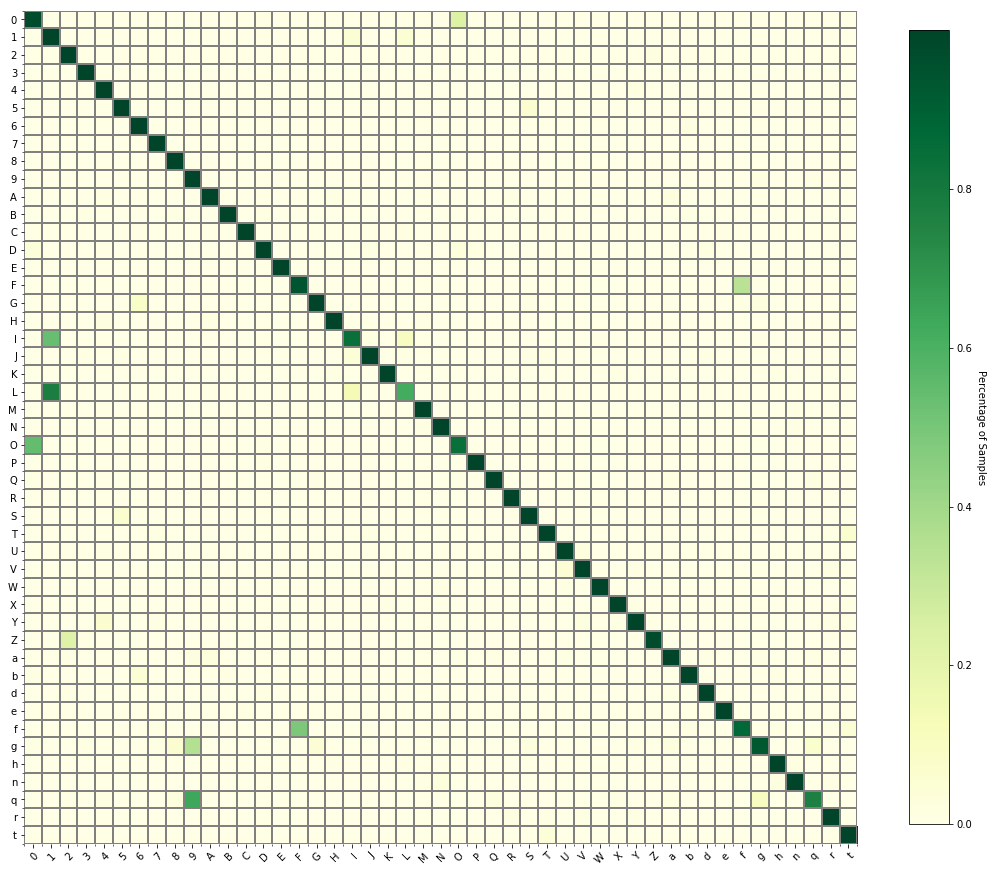

In [17]:
predictions = cnn2.predict(norm_test_features)  # generates a probability for each label
y_pred = np.argmax(predictions, axis=1)  # choose the one with the highest value as the output label

print('Confusion Matrix')
confusion = emnist_utils.generate_confusion_matrix(test['labels'], y_pred)
print(confusion)
emnist_utils.plot_confusion_matrix(confusion, mappings)

## Regularization

### L2 Regularization
This part of the notebook adds a L2 regularizer to the dense layer of the network above.

In [21]:
# (1) First the input layer
inputs = keras.Input(shape=(28,28,), name='emnist_inp')
x = layers.Reshape((28, 28, 1))(inputs)  # since images are gray scale, they have only one channel

# (2.1) Learn 128 different filters, each 3x3 in size, with valid pooling, and (1,1) stride size
x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(x)  # 2 convolutional layers
# (3.1) Pooling layer
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# (2.2) Learn 64 different filters, each 3x3 in size, with valid pooling, and (1,1) stride size
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)  # 2 convolutional layers
# (3.2) Pooling layer
x = layers.MaxPooling2D(pool_size=(2, 2))(x)


# (4) Dimensions after pooling are 5x5x64. The 28x28 image is now 5x5 with 64 filters
x = layers.Flatten()(x)

# (5) Traditional dense/FC layers to use these inputs for classification
# This part is similar to previous model
x = layers.Dense(256, activation='relu', 
                 kernel_regularizer=keras.regularizers.l2(l=0.001), 
                 name='dense_1')(x)
x = layers.Dense(128, activation='relu', 
                 kernel_regularizer=keras.regularizers.l2(l=0.001),
                 name='dense_2')(x)
outputs = layers.Dense(47, activation='softmax', name='predictions')(x)

cnn2_l2 = keras.Model(inputs=inputs, outputs=outputs, name='cnn_model_L2')
cnn2_l2.summary()

Model: "cnn_model_L2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emnist_inp (InputLayer)      [(None, 28, 28)]          0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 128)       1280      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 10, 10, 64)       

In [22]:
# Setup TensorBoard logging
# Make a subdirectory with date and time formatted string to keep track of runs
logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Register a callback with Keras to call after every epoch is completed
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1, write_images=True)

# Creates a file writer for the log directory. Used to log the first image
file_writer = tf.summary.create_file_writer(logdir)

#with file_writer.as_default():
#  tf.summary.image("Training data", np.reshape(train['features'][0], (-1, 28, 28, 1)), step=0)

In [23]:
# Lets compile the model and train it
cnn2_l2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# take a small part of the test set as a validation set
val_test_features = norm_test_features[:5000]  # there are 116K test samples
val_test_labels = one_hot_test_labels[:5000]

# Note the addition of the validation data and callback in the training loop
history = cnn2_l2.fit(norm_train_features, one_hot_train_labels,
                   epochs=10, batch_size=128,
                   validation_data=(val_test_features, val_test_labels),
                   callbacks=[tensorboard_callback])

Train on 697932 samples, validate on 5000 samples
Epoch 1/10
697932/697932 [==============================] - 109s 156us/sample - loss: 0.5136 - accuracy: 0.8646 - val_loss: 0.3810 - val_accuracy: 0.8928
Epoch 2/10
697932/697932 [==============================] - 109s 156us/sample - loss: 0.3651 - accuracy: 0.8903 - val_loss: 0.3473 - val_accuracy: 0.8960
Epoch 3/10
697932/697932 [==============================] - 109s 156us/sample - loss: 0.3376 - accuracy: 0.8955 - val_loss: 0.3223 - val_accuracy: 0.8970
Epoch 4/10
697932/697932 [==============================] - 109s 156us/sample - loss: 0.3236 - accuracy: 0.8981 - val_loss: 0.3089 - val_accuracy: 0.9034
Epoch 5/10
697932/697932 [==============================] - 109s 156us/sample - loss: 0.3138 - accuracy: 0.9002 - val_loss: 0.3042 - val_accuracy: 0.9042
Epoch 6/10
697932/697932 [==============================] - 109s 156us/sample - loss: 0.3068 - accuracy: 0.9013 - val_loss: 0.3118 - val_accuracy: 0.8988
Epoch 7/10
697932/697932 [

In [24]:
# Evaluate the model on the test set
cnn2_l2.evaluate(norm_test_features, one_hot_test_labels, 47)

116323/116323 [==============================] - 11s 92us/sample - loss: 0.3089 - accuracy: 0.9001


[0.3089260218638535, 0.90011436]

## Dropout Based Regularization

In [30]:
import os, datetime
# Setup TensorBoard logging
# Make a subdirectory with date and time formatted string to keep track of runs
logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Register a callback with Keras to call after every epoch is completed
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1, write_images=True)

# Creates a file writer for the log directory. Used to log the first image
file_writer = tf.summary.create_file_writer(logdir)

In [31]:
# (1) First the input layer
inputs = keras.Input(shape=(28,28,), name='emnist_inp')
x = layers.Reshape((28, 28, 1))(inputs)  # since images are gray scale, they have only one channel

# (2.1) Learn 128 different filters, each 3x3 in size, with valid pooling, and (1,1) stride size
x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(x)  # 2 convolutional layers
# (3.1) Pooling layer
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
# (4.1) Dropout Layer, dropping 20% of the connection
x = layers.Dropout(0.2)(x) 

# (2.2) Learn 64 different filters, each 3x3 in size, with valid pooling, and (1,1) stride size
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)  # 2 convolutional layers
# (3.2) Pooling layer
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
# (4.2) Dropout Layer, dropping 20% of the connection
x = layers.Dropout(0.2)(x) 

# (4) Dimensions after pooling are 5x5x64. The 28x28 image is now 5x5 with 64 filters
x = layers.Flatten()(x)

# (5) Traditional dense/FC layers to use these inputs for classification
# This part is similar to previous model
x = layers.Dense(256, activation='relu', name='dense_1')(x)
x = layers.Dense(128, activation='relu', name='dense_2')(x)

outputs = layers.Dense(47, activation='softmax', name='predictions')(x)

cnn2_dropout = keras.Model(inputs=inputs, outputs=outputs, name='cnn_model_dropout')
cnn2_dropout.summary()

Model: "cnn_model_dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emnist_inp (InputLayer)      [(None, 28, 28)]          0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 128)       1280      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 12, 12, 64)  

In [34]:
# Lets compile the model and train it
cnn2_dropout.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# take a small part of the test set as a validation set
val_test_features = norm_test_features[:5000]  # there are 116K test samples
val_test_labels = one_hot_test_labels[:5000]

# Note the addition of the validation data and callback in the training loop
history = cnn2_dropout.fit(norm_train_features, one_hot_train_labels,
                   epochs=10, batch_size=128,
                   validation_data=(val_test_features, val_test_labels)
                          ) #,
                  # callbacks=[tensorboard_callback])

Train on 697932 samples, validate on 5000 samples
Epoch 1/10
697932/697932 [==============================] - 117s 168us/sample - loss: 0.2538 - accuracy: 0.9043 - val_loss: 0.2470 - val_accuracy: 0.9094
Epoch 2/10
697932/697932 [==============================] - 117s 168us/sample - loss: 0.2432 - accuracy: 0.9071 - val_loss: 0.2450 - val_accuracy: 0.9078
Epoch 3/10
697932/697932 [==============================] - 117s 168us/sample - loss: 0.2375 - accuracy: 0.9085 - val_loss: 0.2494 - val_accuracy: 0.9060
Epoch 4/10
697932/697932 [==============================] - 117s 168us/sample - loss: 0.2333 - accuracy: 0.9098 - val_loss: 0.2444 - val_accuracy: 0.9102
Epoch 5/10
697932/697932 [==============================] - 117s 168us/sample - loss: 0.2301 - accuracy: 0.9103 - val_loss: 0.2423 - val_accuracy: 0.9070
Epoch 6/10
697932/697932 [==============================] - 117s 168us/sample - loss: 0.2272 - accuracy: 0.9112 - val_loss: 0.2419 - val_accuracy: 0.9100
Epoch 7/10
697932/697932 [

In [36]:
# Evaluate the model on the test set
cnn2_dropout.evaluate(norm_test_features, one_hot_test_labels, 47)

116323/116323 [==============================] - 10s 88us/sample - loss: 0.2588 - accuracy: 0.9069


[0.25879781841594607, 0.9068714]

## Batch Normalization
Adding batchnormalization in the network

In [37]:
import os, datetime

# sets the log directory as a subdirectory of the folder this python notebook is store in
logs_base_dir = "./logs"  

# If the directory does not exist, create it
os.makedirs(logs_base_dir, exist_ok=True)  

# Make a subdirectory with date and time formatted string to keep track of runs
logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Register a callback with Keras to call after every epoch is completed
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1, write_images=True)

# Creates a file writer for the log directory. Used to log the first image
file_writer = tf.summary.create_file_writer(logdir)


In [39]:
# (1) First the input layer
inputs = keras.Input(shape=(28,28,), name='emnist_inp')
x = layers.Reshape((28, 28, 1))(inputs)  # since images are gray scale, they have only one channel

# (2.1) Learn 128 different filters, each 3x3 in size, with valid pooling, and (1,1) stride size
x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(x)
# (5.1) BatchNormalization added between conv layer
x = layers.BatchNormalization()(x)
# (4.1) Dropout Layer, dropping 20% of the connection
x = layers.Dropout(0.2)(x) 

x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(x)  # 2 convolutional layers
# (5.2) BatchNormalization added between conv layer
x = layers.BatchNormalization()(x)
# (4.2) Dropout Layer, dropping 20% of the connection
x = layers.Dropout(0.2)(x)

# (3.1) Pooling layer
x = layers.MaxPooling2D(pool_size=(2, 2))(x)


# (2.2) Learn 64 different filters, each 3x3 in size, with valid pooling, and (1,1) stride size
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
# (5.3) BatchNormalization added between conv layer
x = layers.BatchNormalization()(x)
# (4.3) Dropout Layer, dropping 20% of the connection
x = layers.Dropout(0.2)(x) 

x = layers.Conv2D(64, (3, 3), activation='relu')(x)  # 2 convolutional layers
# (5.4) BatchNormalization added between conv layer
x = layers.BatchNormalization()(x)
# (4.4) Dropout Layer, dropping 20% of the connection
x = layers.Dropout(0.2)(x) 

# (3.2) Pooling layer
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# (6) Dimensions after pooling are 5x5x64. The 28x28 image is now 5x5 with 64 filters
x = layers.Flatten()(x)

# (7) Traditional dense/FC layers to use these inputs for classification
# This part is similar to previous model
x = layers.Dense(256, activation='relu', name='dense_1')(x)
x = layers.Dense(128, activation='relu', name='dense_2')(x)

outputs = layers.Dense(47, activation='softmax', name='predictions')(x)

cnn2_do_bn = keras.Model(inputs=inputs, outputs=outputs, name='cnn_model_dropout_batch_norm')
cnn2_do_bn.summary()

Model: "cnn_model_dropout_batch_norm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emnist_inp (InputLayer)      [(None, 28, 28)]          0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 28, 128)       1280      
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 28, 28, 128)       512       
_________________________________________________________________
dropout_12 (Dropout)         (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 28, 28, 128)       147584    
_________________________________________________________________
batch_normalization_v2_2 (Ba (None, 28

In [ ]:
# Lets compile the model and train it
cnn2_do_bn.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# take a small part of the test set as a validation set
val_test_features = norm_test_features[:5000]  # there are 116K test samples
val_test_labels = one_hot_test_labels[:5000]

# Note the addition of the validation data and callback in the training loop
history = cnn2_do_bn.fit(norm_train_features, one_hot_train_labels,
                   epochs=15, batch_size=128,
                   validation_data=(val_test_features, val_test_labels)
                          ) 

Train on 697932 samples, validate on 5000 samples
Epoch 1/15
697932/697932 [==============================] - 194s 278us/sample - loss: 0.2936 - accuracy: 0.8925 - val_loss: 0.3486 - val_accuracy: 0.8868
Epoch 2/15
697932/697932 [==============================] - 193s 277us/sample - loss: 0.2654 - accuracy: 0.9013 - val_loss: 0.3088 - val_accuracy: 0.8966
Epoch 3/15
697932/697932 [==============================] - 193s 277us/sample - loss: 0.2515 - accuracy: 0.9052 - val_loss: 0.3143 - val_accuracy: 0.8890
Epoch 4/15
697932/697932 [==============================] - 193s 277us/sample - loss: 0.2418 - accuracy: 0.9080 - val_loss: 0.2788 - val_accuracy: 0.8902
Epoch 5/15
697932/697932 [==============================] - 193s 277us/sample - loss: 0.2336 - accuracy: 0.9100 - val_loss: 0.2554 - val_accuracy: 0.9058
Epoch 6/15
697932/697932 [==============================] - 193s 277us/sample - loss: 0.2273 - accuracy: 0.9118 - val_loss: 0.2629 - val_accuracy: 0.8980
Epoch 7/15
697932/697932 [

In [ ]:
# Evaluate the model on the test set
cnn2_do_bn.evaluate(norm_test_features, one_hot_test_labels, 47)